In [4]:

#load standard libraries and set graphing styles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import  struct 
import os
import seaborn as sns
from skimage import filters
from skimage.filters import threshold_multiotsu
import scipy
import operator
from scipy.optimize import minimize
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle
from scipy import stats
from collections import Counter
import json
import re
from array import array

large = 18
med = 18
small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid')

def loadMI(filename):
    size=os.path.getsize(filename)
    current=[]
    
    baseTime=os.path.getctime(filename)
    distance=[]
    times=[]
    velocity=[]
    distances=[]
    data = array('B')
    isSpectroscopy=False
    bufferLabels = []
    bufferUnits =[]
    displayRange = [] 
    displayOffset = []
    parameters = {}
    with open(filename, "rb") as file1:
        # Reading form a file
        d=file1.readline()
        chunks=[]
        while d!='data          BINARY\n' and d!='data          BINARY_32\n':
            d=file1.readline()
            
            d=d.decode('ascii')
            dd=d.strip().split(' ')
            
            if len(dd)>1:
                ddClean =" ".join( [x for x in dd[1:] if x!=' ']).strip() .replace('FALSE','False').replace('TRUE','True')
                 
                try:
                    ddClean=eval(ddClean)
                except:
                    pass
                
                
                parameters[dd[0]]=ddClean
                
            if len(dd)>1 and dd[-1]=='Spectroscopy':
                isSpectroscopy=True
          
            if dd[0]=='bufferLabel':
                bufferLabels.append(" ".join(dd[1:]).strip())
            if dd[0]=='bufferUnit':
                bufferUnits.append(" ".join(dd[1:]).strip())
           
            if dd[0]==('DisplayRange'):
                displayRange.append(float(dd[-1]))
            if dd[0]==('DisplayOffset'):
                displayOffset.append(float(dd[-1]))
                
                    
            if  dd[0]==('bias'):
                bias =float(dd[-1]) 
                
            if  d.startswith('chunk'):
                parts = d.split('\t')
                dist=float(parts[5])
                time0=float(parts[2])
                time=float(parts[3])
                valueO=float(parts[4])
                chunks.append({'points':int(parts[1]),
                               'distperpoint':dist, 
                               'timeperpoint':time,
                               'startValue':valueO,
                               'time0':time0})

        

        
        loc = file1.tell()
        binarySize =size-loc
        data.fromfile(file1,binarySize )

        if not isSpectroscopy:
            images = []
            cc=0
            xPixels = parameters['xPixels']
            yPixels = parameters['yPixels']
            for i in range(0,len(bufferLabels)):
                img = np.zeros((xPixels,yPixels))
                 
                for j in range(0,xPixels):
                    for k in range(0,yPixels):
                        img[j,k] = struct.unpack('i', data[cc:cc+4])[0]
                        cc+=4
                        
                images.append({ 'img':img * displayRange[i] + displayOffset[i],
                                'label':bufferLabels[i],
                                'unit':bufferUnits[i],
                                'widthUnit' : 'um',
                                'heightUnit' : 'um',
                               })
            return parameters,images
        else:
            i=0
            while True:
                    cDist=0
                    for chunk in chunks:
                        chunkDist=[]
                        chunkCurrent=[]
                        
                        if isSpectroscopy:
                            cDist=chunk['startValue']
                            

                        for j in range(0,chunk['points']):
                            try:
                                f=(struct.unpack('<f', data[i:i+4]))
                            except:
                                return parameters,current,times,np.array(velocity) ,np.array(distances),bufferLabels,bufferUnits
                            chunkCurrent.append(f)
                            cDist+=chunk['distperpoint']
                            chunkDist.append(cDist)
                            i+=4
                    
                        dist=np.array(chunkDist)
                        if len(dist)>0:
                            distance.append(dist)
                            current.append(np.array(chunkCurrent).ravel()) 
                            totalTime=len(chunkDist)*chunk['timeperpoint']
                            time= chunk['time0']+ np.linspace(0, totalTime, len(chunkDist))
                        
                            times.append(time )
                            if len(dist)>0:
                                distances.append((dist[0]-dist[-1]))
                                velocity.append((dist[0]-dist[-1])/(time[0]-time[-1]))
                                


In [5]:
def StepFlatten(data,verbose=False):
    #determine coordinates
    X, Y = np.meshgrid(np.linspace(0, 1, data.shape[0]),  np.linspace(0, 1, data.shape[1]), copy=False)
    X = X.flatten()
    Y = Y.flatten()

    #iteration variable
    ravelData=np.ravel(data)
    flattenedData =np.zeros_like(ravelData)

    #calculate all the terms for third order plane fit
    terms2 = [X*0+1, X, Y, X**2, Y**2, X**3, Y**3,X*Y,X**2*Y,Y**2*X,X**2*Y**2,X**3*Y, Y**3*X ,X**3*Y**2, Y**3*X**2, Y**3*X**3]
    A = np.array(terms2).T
    for repeat in range(10):

        #the histogram allows us to segment the image into planes
        m=np.min(ravelData)
        M=np.max(ravelData)
        r=M-m
        m=m-r*.25
        M=M+r*.25

        bins=np.arange(m,M,(M-m)/100)

        #meanshift is a 2D routine, but our data is 1D in height
        ff=ravelData.reshape(-1, 1)
        bandwidth = estimate_bandwidth(ff, quantile=0.2,  n_samples=1000)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(ff)

        labels = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(labels)
        n_clusters_ = len(labels_unique)

        for k in labels_unique:
            my_members = labels == k
            mean = np.mean(ravelData[my_members])
            flattenedData[my_members]=ravelData[my_members]-mean
        if verbose:
            plt.imshow(np.reshape( flattenedData, newshape=[data.shape[0],data.shape[1]]), cmap='gray')
            plt.show()

        coeff, r, rank, s = np.linalg.lstsq(A,flattenedData,rcond=None)
        p=coeff[0]*terms2[0]
        for i in range(1,len(terms2)):
            p+=coeff[i]*terms2[i]

        ravelData=ravelData-p
        if verbose:
            plt.imshow(np.reshape( ravelData, newshape=[data.shape[0],data.shape[1]]), cmap='gray')
            plt.show()    
    
    minData=np.min([ np.mean( ravelData[labels==i]  ) for i in range(np.max(labels))])
    ravelData=ravelData-minData
    return np.reshape( ravelData, newshape=[data.shape[0],data.shape[1]]),np.reshape(labels, newshape=[data.shape[0],data.shape[1]]), np.histogram(ravelData,bins=50)
    


In [19]:
file = r'E5__240703_114329.mi'  
 
imageParams,images =loadMI(file) 
imageParams

print(np.max(images[0]['img'])*1e-6, np.min(images[0]['img'])*1e-6)



19.978714216566797 -3.044122596233203


0.1

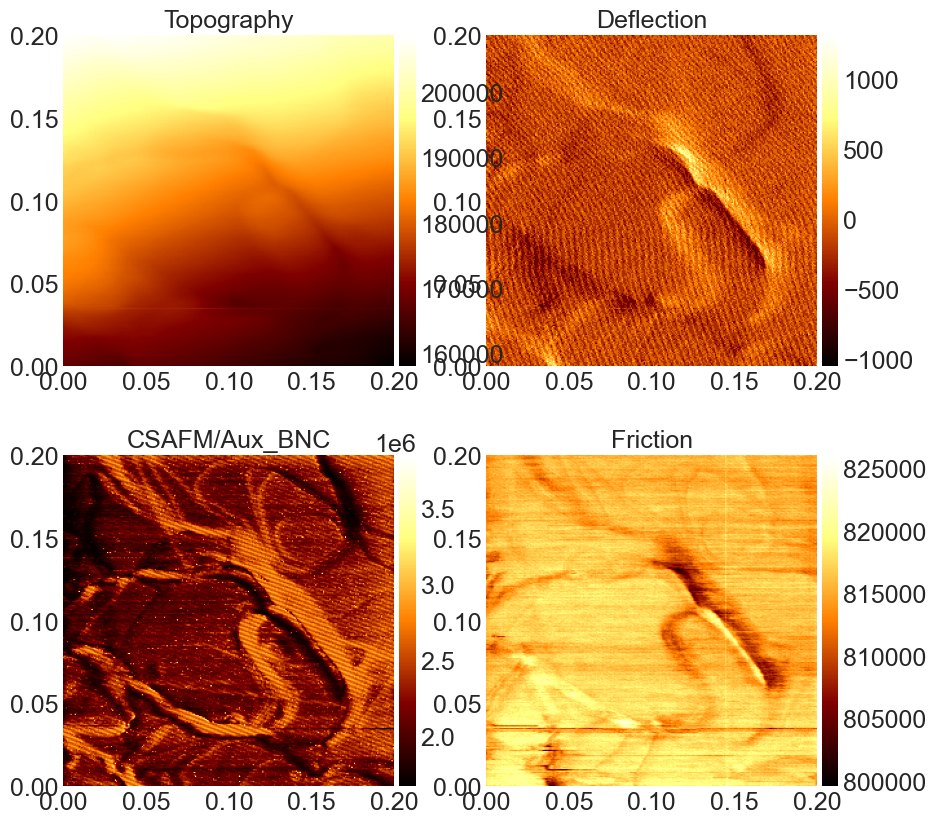

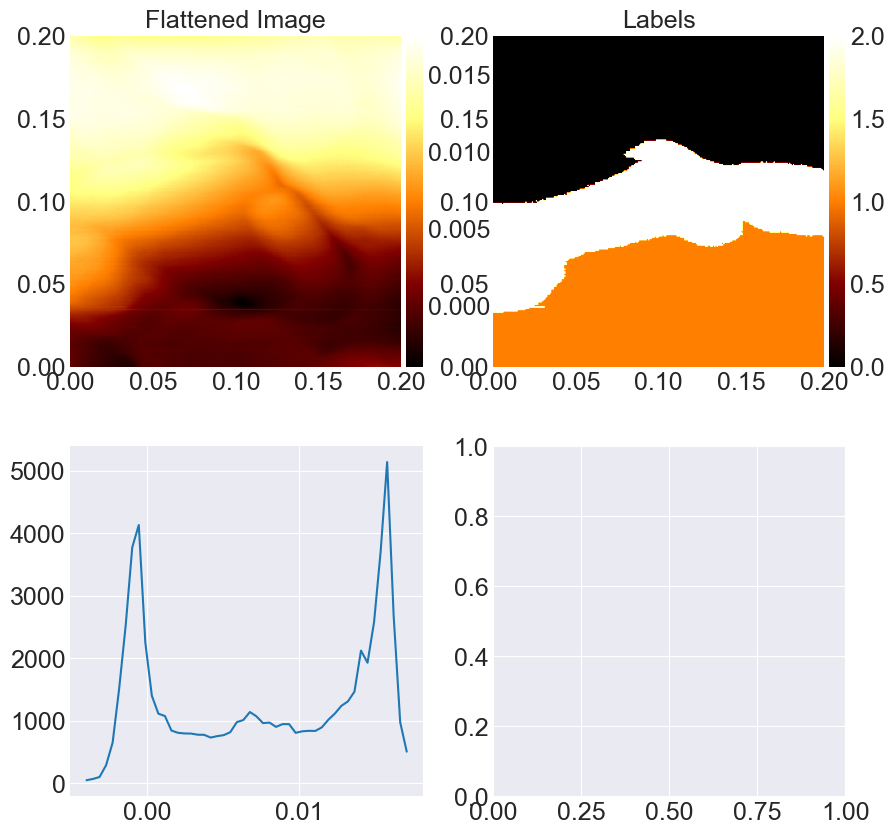

In [33]:
file = r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240715_C11_B\Flat_csimage_240715_111147.mi'  
 
imageParams,images  =loadMI(file) 

_,ax=plt.subplots(2,2,figsize=(10,10))
ax=ax.ravel()   
for i in range(0,len(images)):
    img=ax[i].imshow(images[i]['img'], cmap='afmhot', extent=[0, 1e6*imageParams['xLength'], 0,1e6*imageParams['yLength']])
    ax[i].set_title(images[i]['label'])
    ax[i].grid(None)
    #add a colormap to the right of each image
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img , cax=cax)
plt.show()    
print(imageParams[ 'bias'])

flat,labels,hFlat=StepFlatten(images[0]['img']*1e-6)


_,ax=plt.subplots(2,2,figsize=(10,10))
ax=ax.ravel()   
images = [{'img':flat,'label':'Flattened Image'},{'img':labels,'label':'Labels'} ]
for i in range(0,len(images)):
    img=ax[i].imshow(images[i]['img'], cmap='afmhot', extent=[0, 1e6*imageParams['xLength'], 0,1e6*imageParams['yLength']])
    ax[i].set_title(images[i]['label'])
    ax[i].grid(None)
    #add a colormap to the right of each image
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img , cax=cax)
   

 
ax[2].plot(hFlat[1][:-1],hFlat[0])
plt.show()


In [34]:
def extractBackground(my_members, selectedData, terms2,verbose):
    lTerms =[]
    for x in terms2:
        lTerms.append(x[my_members])

    A = np.array(lTerms).T
    coeff, r, rank, s = np.linalg.lstsq(A,selectedData,rcond=None)

    if verbose:
        testImage =np.zeros([256,256],dtype=np.float32)
        for i in range(len(lTerms[0])):
            testImage[int(255*lTerms[2][i]), int(lTerms[1][i]*255) ]=selectedData[i]
        plt.imshow(testImage,cmap="gray")
        plt.show()
    return coeff

def IterFlatten(data,backgroundSelect=0,verbose=False):

    #determine coordinates
    X, Y = np.meshgrid(np.linspace(0, 1, data.shape[0]),  np.linspace(0, 1, data.shape[1]), copy=False)
    X = X.flatten()
    Y = Y.flatten()

    #iteration variable
    flattenedData=np.ravel(data)

    #calculate all the terms for third order plane fit
    terms2 = [X*0+1, X, Y, X**2, Y**2, X**3, Y**3,X*Y,X**2*Y,Y**2*X,X**2*Y**2,X**3*Y, Y**3*X ,X**3*Y**2, Y**3*X**2, Y**3*X**3]


    for repeat in range(10):
        
        #the histogram allows us to segment the image into planes
        m=np.min(flattenedData)
        M=np.max(flattenedData)
        r=M-m
        m=m-r*.25
        M=M+r*.25

        bins=np.arange(m,M,(M-m)/100)

        #meanshift is a 2D routine, but our data is 1D in height
        ff=flattenedData.reshape(-1, 1)
        bandwidth = estimate_bandwidth(ff, quantile=0.2,  n_samples=1000)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(ff)

        labels = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(labels)
        n_clusters_ = len(labels_unique)
        
        clusterValue = {}
        clusterSize ={}
        for k in labels_unique:
            my_members = labels == k
            selectedData = flattenedData[my_members]
            if (len(selectedData)>800):
                clusterValue[k] = np.mean(selectedData)
                clusterSize[k] = len(selectedData)
        sorted_byValue = sorted(clusterValue.items(), key=operator.itemgetter(1))
        sorted_bySize = sorted(clusterSize.items(), key=operator.itemgetter(1))
        
        if backgroundSelect==0:
            for k in sorted_byValue:
                my_members = (labels == k[0])
                selectedData = flattenedData[my_members]
                if len(selectedData)>1000:
                    coeff=extractBackground(my_members, selectedData, terms2,verbose)
                    break
        elif backgroundSelect==1:
            k=sorted_byValue[-1][0]
            my_members = (labels == k)
            selectedData = flattenedData[my_members]
            coeff=extractBackground(my_members, selectedData, terms2,verbose)
        elif backgroundSelect==2:
            k=sorted_bySize[-1][0]
            my_members = (labels == k)
            selectedData = flattenedData[my_members]
            coeff=extractBackground(my_members, selectedData, terms2,verbose)
        else:
            coeff=[]
            cc=0
            for k in range(0,n_clusters_):
                my_members = labels == k
                selectedData = flattenedData[my_members]
                x=terms2[1][my_members]
                y=terms2[2][my_members]
                f=len(selectedData)*np.std(x)*np.std(y)
                if len(selectedData)>1000:
                    cs=extractBackground(my_members, selectedData, terms2,verbose)
                    if (len(coeff)==0):
                        coeff=cs*f
                    else:
                        coeff+=cs*f
                    cc+=f
            coeff=np.array(coeff)/cc

        
            
                

        #calculate the background plane
        p=coeff[0]*terms2[0]
        for i in range(1,len(terms2)):
            p+=coeff[i]*terms2[i]
            
        flattenedData -= p
        
        if verbose:
            plt.imshow(np.reshape( flattenedData, newshape=[data.shape[0],data.shape[0]]), cmap='gray')
            plt.show()

            plt.hist(flattenedData, bins)
            plt.show()
            
    ff=flattenedData.reshape(-1, 1)
    bandwidth = estimate_bandwidth(ff, quantile=0.2,  n_samples=1000)            
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(ff)

    labels = ms.labels_

    return np.reshape(flattenedData, newshape=[data.shape[0],data.shape[0]]), np.reshape(labels, newshape=[data.shape[0],data.shape[0]]), np.histogram(flattenedData,bins)


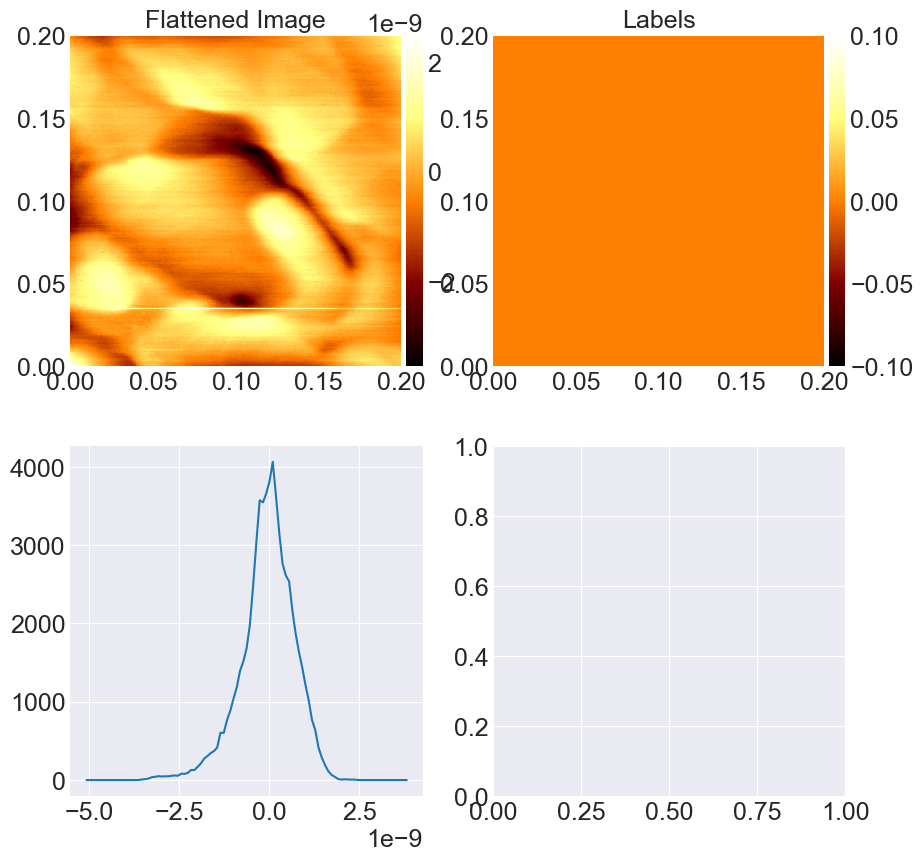

In [35]:
fData,labels,hist=IterFlatten(images[0]['img']*1e-6,0,False)

_,ax=plt.subplots(2,2,figsize=(10,10))
ax=ax.ravel()   
images = [{'img':fData,'label':'Flattened Image'},{'img':labels,'label':'Labels'} ]
for i in range(0,len(images)):
    img=ax[i].imshow(images[i]['img'], cmap='afmhot', extent=[0, 1e6*imageParams['xLength'], 0,1e6*imageParams['yLength']])
    ax[i].set_title(images[i]['label'])
    ax[i].grid(None)
    #add a colormap to the right of each image
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img , cax=cax)
    
ax[2].plot(hist[1][:-1],hist[0])    
plt.show()    

In [8]:
def CreateTexture(data,minD,maxD,file, width,height):
    dataNorm=((data-minD)/(maxD-minD))*255
    dataNorm[dataNorm<50]=50
    dataNorm[0,0]=0
    dataNorm[dataNorm>255]=255

    fig = plt.figure()
    plt.imshow(dataNorm, cmap=plt.get_cmap("gist_heat"))
    plt.axis('off')
    

    textureFile =folderName + "\\processed\\" + file + "_texture.jpg"
    plt.savefig( textureFile, bbox_inches='tight', pad_inches = 0)
    plt.show()
    
    fig = plt.figure()
    if width>1000 or height>1000:
        unit="µm"
        width=width/1000
        height=height/1000
    else:
        unit ="nm"
        
        
    dataNorm=data+.0001
    dataNorm[dataNorm<minD]=minD
    dataNorm[dataNorm>maxD]=maxD
    
    shw=plt.imshow(dataNorm, cmap=plt.get_cmap("gist_heat"),extent=(0, width,0, height))
    bar = plt.colorbar(shw)
    # show plot with labels
    plt.xlabel(unit)
    plt.ylabel(unit)
    bar.set_label('Height (nm)')
    
    textureFile =folderName + "\\processed\\" + file + "_drawn.jpg"
    plt.savefig( textureFile, bbox_inches='tight', pad_inches = 0)
    plt.show()
    
    
    
def CreateHistogram(data,minD,maxD,file, imageArea):
    bins=50#np.arange(minD,maxD,(maxD-minD)/100)
    hFlat = np.histogram(np.ravel(data),bins=bins)
    bins=hFlat[1][:-1]
    vals=hFlat[0]/np.sum(hFlat[0])*imageArea/1000/1000
    b=plt.bar( bins,(vals),width=1.0)
    plt.xlabel("Height (nm)")
    plt.ylabel("Area (um^2)")
    histFile = folderName + "\\processed\\" + file + "_hist.svg"
    plt.savefig(histFile , bbox_inches='tight', pad_inches = 0)
    plt.show()

def CreateProfileLines(data,minD,maxD,Xrange,file)   :    
    bestHLine=0
    bestHStd=0
    smoothHLine=0
    smoothHStd=1e10

    bestVLine=0
    bestVStd=0
    smoothVLine=0
    smoothVStd=1e10

    maxH=0
    maxHV=0
    for i in range(data.shape[0]):
        lineS = np.std( data[i,:])
        
        if lineS>maxHV:
            maxHV=lineS
            maxH=i
            
        
    maxV=np.argmax(data[maxH,:])

    for i in range(4,data.shape[0]-4):
        if np.abs(i-maxH)>10:
            lineS = np.std( data[i,:])

            if lineS>bestHStd:
                bestHStd=lineS
                bestHLine=i
            if lineS<smoothHStd:
                smoothHStd=lineS
                smoothHLine=i

    for i in range(4,data.shape[0]-4):
        if np.abs(i-maxV)>10:
            lineS = np.std( data[:,i])
            if lineS>bestVStd:
                bestVStd=lineS
                bestVLine=i
            if lineS<smoothVStd:
                smoothVStd=lineS
                smoothVLine=i
    
    profileLines={ "horizontal":[data[bestHLine,:].tolist(),    data[smoothHLine,:].tolist()], "vertical":[data[:,bestVLine].tolist(),    data[:,smoothVLine].tolist()]}
    
    dataNorm=((data-minD)/(maxD-minD))*255
    dataNorm[dataNorm<0]=0
    dataNorm[0,0]=0
    dataNorm[dataNorm>255]=255

    fig, ax1 = plt.subplots()
    unit='nm'
    maxDistance=Xrange[0] #in nm
    step=Xrange[0]/len(profileLines["horizontal"][0])
    if maxDistance>1000:
        maxDistance/=1000
        step/=1000
        unit='uM'
           
    ax1.plot(np.arange(0,maxDistance,step) , profileLines["horizontal"][0],color='blue')
    ax1.plot(np.arange(0,maxDistance,step),profileLines["horizontal"][1],color='black')
    ax1.set_xlabel('Distance (' + unit + ')')
    ax1.set_ylabel('Height (nm)')
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.01,.6,0.3,0.3])
    ax2.set_axes_locator(ip)
    ax2.imshow(dataNorm, cmap=plt.get_cmap("gist_heat"))
    ax2.axis('off')
    ax2.axhline(y=bestHLine-1,linewidth=3,color='cornflowerblue')
    ax2.axhline(y=smoothHLine-1,linewidth=3,color='gray')
    
    ax2.axhline(y=bestHLine,color='blue')
    ax2.axhline(y=smoothHLine,color='black')
    file = os.path.basename(filename).replace(".npy","")
    textureFile =folderName + "\\processed\\" + file + "_hprofile.svg"
    plt.savefig( textureFile, bbox_inches='tight', pad_inches = 0)
    plt.show()        
    
    fig, ax1 = plt.subplots()
    unit='nm'
    maxDistance=Xrange[1] #in nm
    step=Xrange[1]/len(profileLines["horizontal"][0])
    if maxDistance>1000:
        maxDistance/=1000
        step/=1000
        unit='uM'
    ax1.plot(np.arange(0,maxDistance,step) ,profileLines["vertical"][0],color='blue')
    ax1.plot(np.arange(0,maxDistance,step) ,profileLines["vertical"][1],color='black')
    ax1.set_xlabel('Distance (' + unit + ')')
    ax1.set_ylabel('Height (nm)')
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.01,.6,0.3,0.3])
    ax2.set_axes_locator(ip)
    ax2.imshow(dataNorm, cmap=plt.get_cmap("gist_heat"))
    ax2.axis('off')
    ax2.axvline(x=bestVLine-1,linewidth=3,color='cornflowerblue')
    ax2.axvline(x=smoothVLine-1,linewidth=3,color='gray')
    ax2.axvline(x=bestVLine,color='blue')
    ax2.axvline(x=smoothVLine,color='black')
    file = os.path.basename(filename).replace(".npy","")
    textureFile =folderName + "\\processed\\" + file + "_vprofile.svg"
    plt.savefig( textureFile, bbox_inches='tight', pad_inches = 0)
    plt.show()    
    
    return profileLines

#profileLines=CreateProfileLines(data,minD,maxD,Xrange,fileOut) 

In [9]:
def GetBlobs(data,minD,maxD, dStats, addCol):
    # Read image
    im=((data-minD)/(maxD-minD))*255
    im[im<0]=0
    im[0,0]=0
    im[im>255]=255
    im = im.astype(np.uint8)


    image_gray = im
    blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)


    widths=[]
    heights=[]
    for blob in blobs_doh:
        y, x, r = blob
        widths.append(r)
        x2=int(x+2*r)
        y2=int(y+2*r)
        if x2<data.shape[0] and y2<data.shape[1]:
            heights.append(data[int(x),int(y)]-data[x2,y2])
            
    nBlobs =len(widths)
    blobRadius=np.mean(widths)
    blobHeight=np.mean(heights)
    if np.isnan(nBlobs): nBlobs=0
    if np.isnan(blobRadius): blobRadius=0
    if np.isnan(blobHeight): blobHeight=0
        
    if len(widths)>0:
        dStats[addCol]["Number Blobs"]=nBlobs
        dStats[addCol]["Ave Blob Radius (nm)"]=blobRadius
        dStats[addCol]["Ave Blob Height (nm)"]=blobHeight
    return dStats 

In [10]:
def CreateStats(data,labels,pixelArea):
    stats=[]

    rData=np.ravel(data)    
    lData =np.ravel(labels)
    minD=np.min(rData)
    maxD=np.max(rData)
    meanD=np.mean(rData)
    stdD=np.std(rData)
    roughD =np.sum( np.abs(rData-meanD))/len(rData)
    
    unit="pm"
    rFactor=1000
    if (stdD>1):
        unit="nm"
        rFactor=1
        
        
    areaUnit ="nm^2"    
    area =pixelArea*data.shape[0]*data.shape[1]
    if area>1:
        area=area/1000/1000
        areaUnit = "um^2"
    print(peaks)
    stats.append({
            "Name":"Whole Image",
            "Average value (nm)":meanD,
            "RMS roughness (" + unit +")":stdD*rFactor,
            "Mean roughness (" + unit +")":roughD*rFactor,
            "Skew":scipy.stats.skew(rData),
            "Maximum (nm)":maxD,
            "Minimum (nm)":minD,
            "Area (" + areaUnit + ")": area
        })
    
    
    labels_unique = np.unique(labels)
        
    for k in labels_unique:
        my_members = lData == k
        selectedData = rData[my_members]

        minD=np.min(selectedData)
        maxD=np.max(selectedData)
        meanD=np.mean(selectedData)
        stdD=np.std(selectedData)
        roughD =np.sum( np.abs(selectedData-meanD))/len(rData)
        unit="pm"
        rFactor=1000
        if (stdD>1):
            unit="nm"
            rFactor=1
        areaUnit ="nm^2"    
        area =len(selectedData)*pixelArea
        if area>1000:
            area=area/1000/1000
            areaUnit = "um^2"
        
        stats.append({
                "Name":"layer " + str(k),
                "Average value (nm)":meanD,
                "RMS roughness (" + unit +")":stdD*rFactor,
                "Mean roughness (" + unit +")":roughD*rFactor,
                "Skew":scipy.stats.skew(selectedData),
                "Maximum (nm)":maxD,
                "Minimum (nm)":minD,
                "Area (" + areaUnit + ")": area
            })
        
    return stats


E6_220121_123244.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


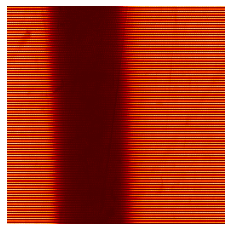

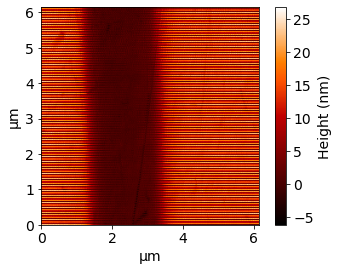

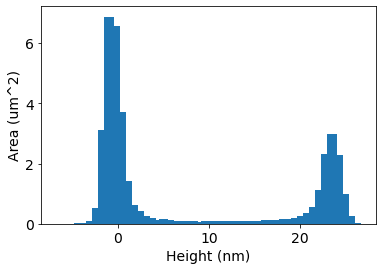

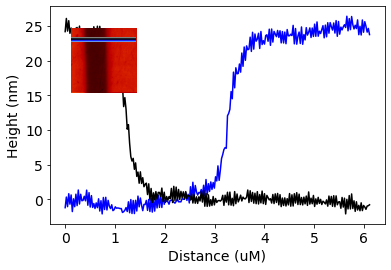

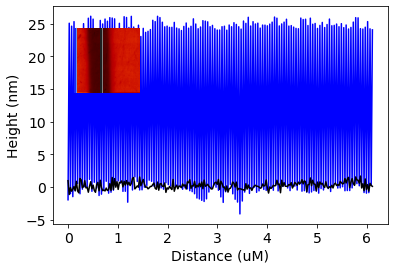

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


E6_220121_130043.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


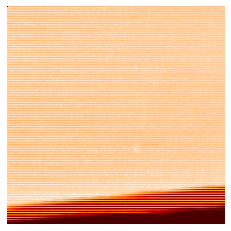

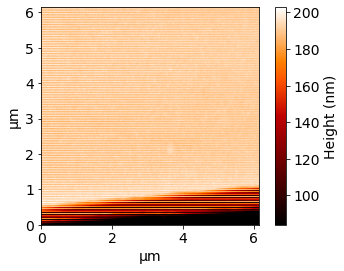

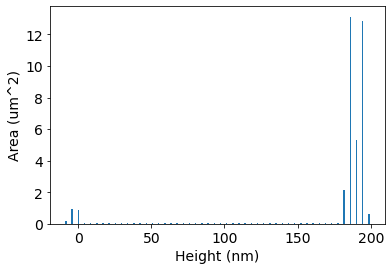

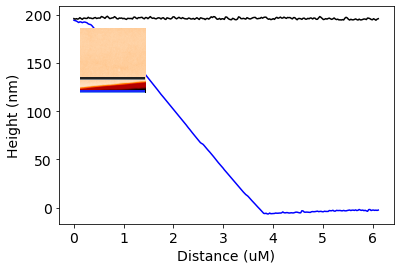

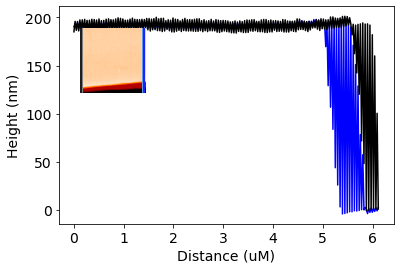

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


E6_220121_130949.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


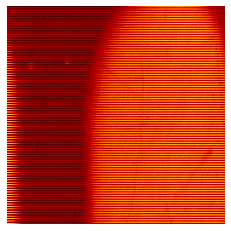

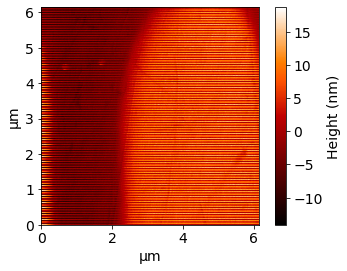

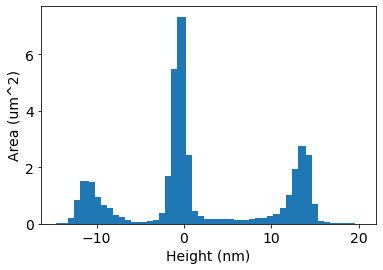

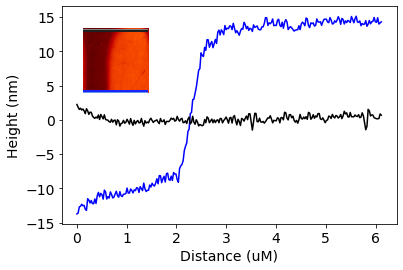

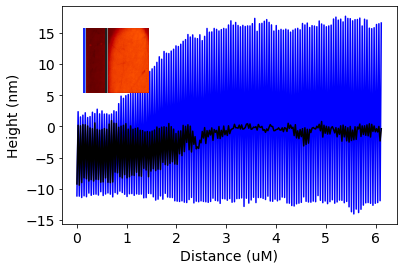

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


E6_220121_132009.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


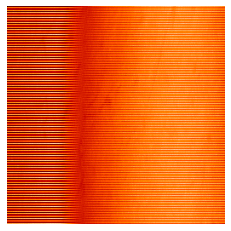

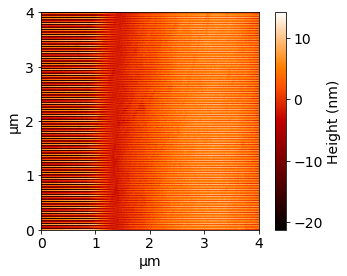

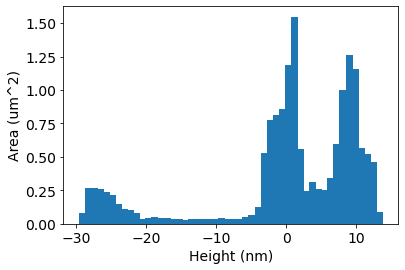

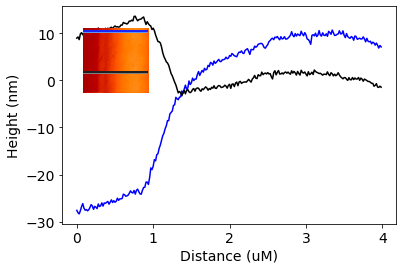

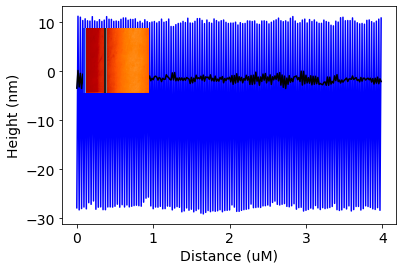

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


E6_220121_132914.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


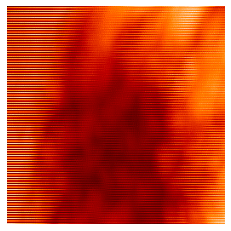

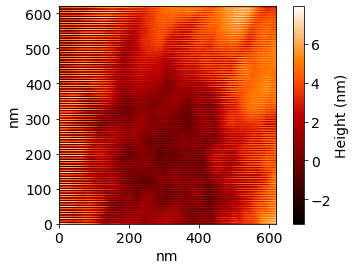

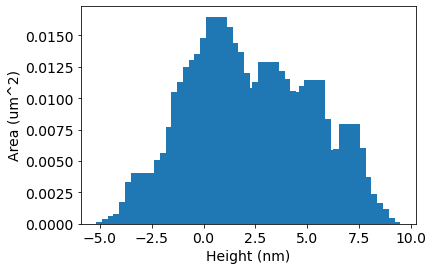

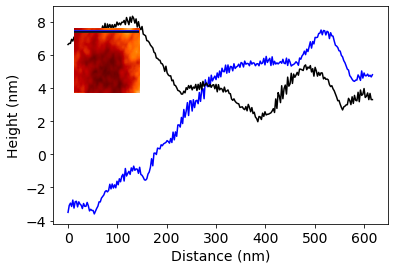

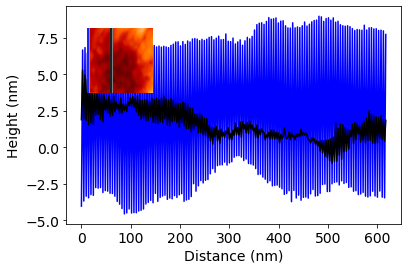

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


s3_220121_134033.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


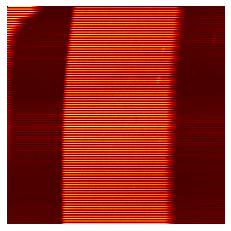

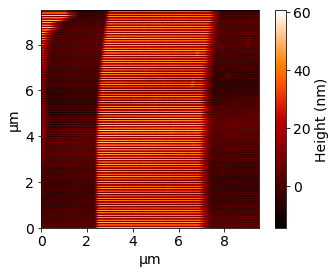

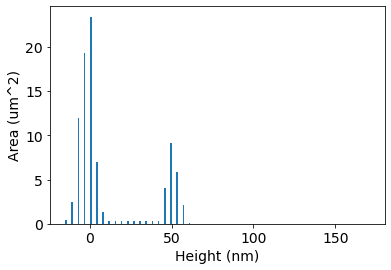

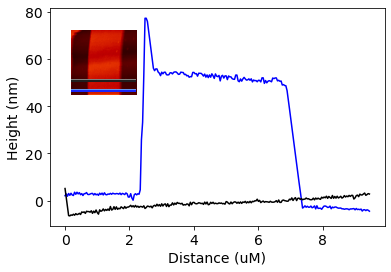

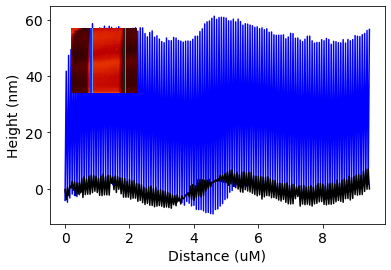

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


s3_220121_140627.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


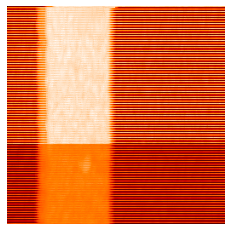

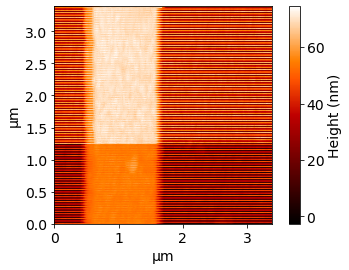

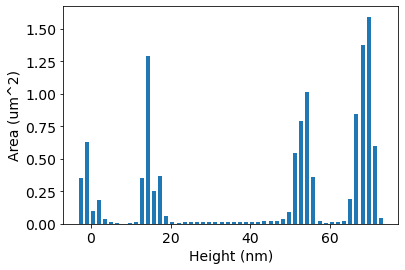

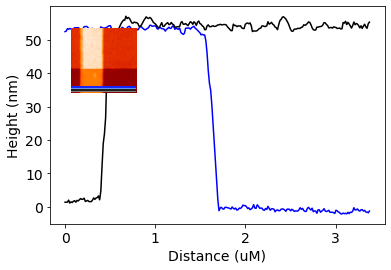

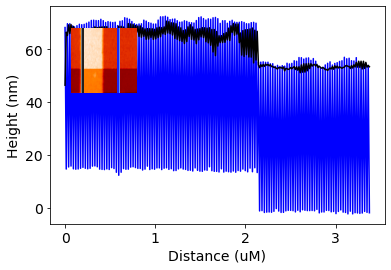

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


s3_220121_142033.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


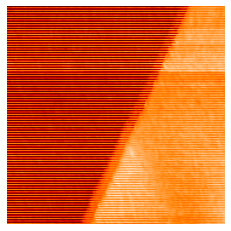

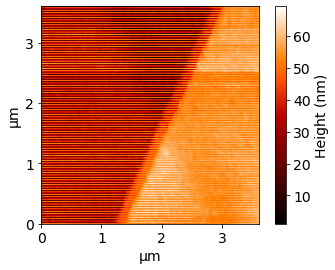

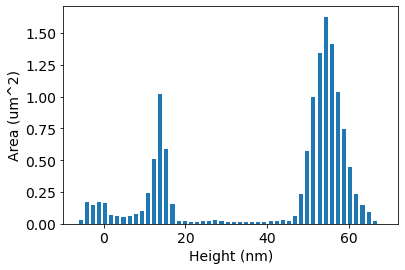

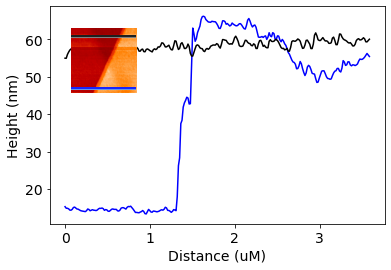

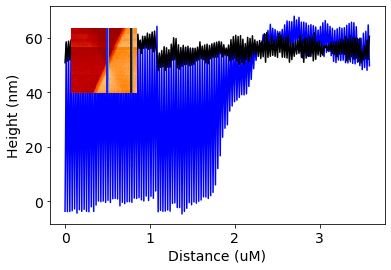

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


s3_220121_144015.npy
(array([ 9, 57, 65, 67, 70, 79, 84, 88, 92, 94], dtype=int64), {'peak_heights': array([ 601., 2039., 1751., 1605., 1701., 1086., 1093., 1126., 1277.,
       1435.])})


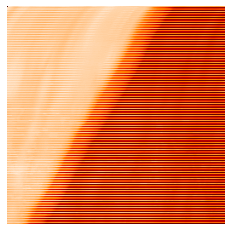

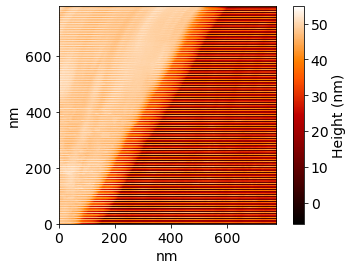

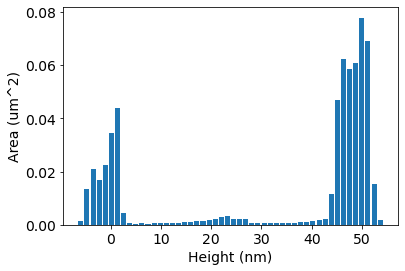

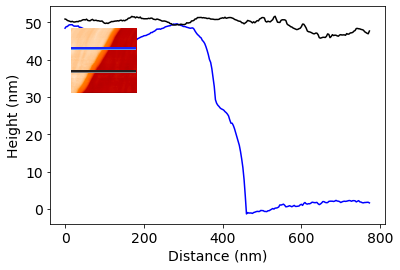

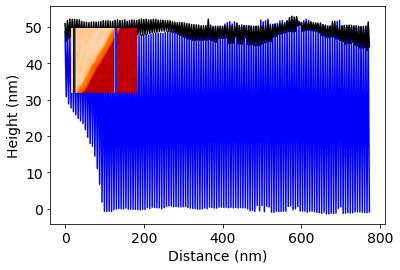

c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [11]:
jsonOut={"tags":tags}
dirs = os.listdir( folderName + "\\processed" )
i=0
activeFile=""
plt.rcParams.update({'font.size': 14}) 
for file in dirs:
    if ".npy" in file and file[0:2]!='R_':
        #try:
            print(file)
            activeFile=file
            filename = folderName + "\\processed\\" + file
            fileOut = os.path.basename(filename).replace(".npy","")
            data = np.load(filename)*1e9
            Xrange = np.load(folderName + "\\processed\\R_" + file)*1e9
            
            pixelArea = Xrange[0]*Xrange[1]/data.shape[0]/data.shape[1]  #nm^2/pixel
            
            data,labels,hist=StepFlatten(data)#IterFlatten(data,2,False)
            
            #plt.imshow(data, cmap='gray')
            #plt.show()
            #plt.imshow(labels)
            #plt.show()

            #bins=hist[1][:-1]
            #val=hist[0]
            #bins=bins[val!=0]
            #val=val[val!=0]
            #plt.plot(bins,val)    
            #plt.show()
            
            dStats = CreateStats(data,labels,pixelArea)

            std=np.std(data)*2
            mean = np.mean(data)
            minD=np.max((np.min(data), mean-std))
            maxD=np.min((np.max(data), mean+std))

            CreateTexture(data,minD,maxD,fileOut,Xrange[0],Xrange[1])
            CreateHistogram(data,minD,maxD,fileOut,Xrange[0]*Xrange[1])
            profileLines=CreateProfileLines(data,minD,maxD,Xrange,fileOut) 
            

            tags2=[]
            for tag in tags:
                tags2.append(tag.upper())

            fileTags=activeFile.replace(".npy","").split("_")
            tags2.append(fileTags[0])
            tags2.append("_".join(fileTags[1:]))            

            itemId = ",".join(tags2).upper()
            tags2.append("AFM")
            jsonOut[i]={ "figName" :file.replace(".npy","") ,"td":itemId}
            payload ={"Title": fileOut.replace(".npy","") ,"stats":dStats,"profilelines":profileLines }

            try:
                read_item = container.read_item(item= itemId, partition_key=itemId)
                read_item['DataJson'] = payload
                read_item['DataFile'] =  fileOut
                read_item['DataFolder'] =  folderName + "\\processed\\" 
                read_item['FileCatalog']={"hist":fileOut + "_hist.svg", 
                                          "hprofile":fileOut + "_hprofile.svg",
                                          "vprofile":fileOut + "_vprofile.svg",
                                          "text":fileOut + "_texture.jpg",
                                          "gwy":fileOut + "_gwy.png",
                                          "height":fileOut + "_height.csv"                                     }
                read_item['Tags'] =tags2
                read_item['DataType'] ='AFM_ITEM'
                read_item["Title"] = itemId
                read_item['CreateNeeded'] =False
             
                response = container.upsert_item(body=read_item)
            except:
                """read_item ={
                           "id":itemId,
                           'DataJson':payload,
                           "Title":itemId,
                           'CreateNeeded':False,
                           'Tags': tags2,
                           'FileCatalog':{"hist":fileOut + "_hist.svg", 
                                          "hprofile":fileOut + "_hprofile.svg",
                                          "vprofile":fileOut + "_vprofile.svg",
                                          "text":fileOut + "_texture.jpg",
                                          "gwy":fileOut + "_gwy.png",
                                          "height":fileOut + "_height.csv"},
                           'DataFile':  fileOut ,
                           'DataFolder':  folderName + "\\processed\\" ,
                           'DataType': 'AFM_ITEM',
                           'Notes': None,
                           'Outcome': None}
                response=container.create_item(body=read_item)"""

            i+=1
        #except:
        #    pass

In [12]:
dirs = os.listdir( folderName + "\\processed" )
i=0
for file in dirs:
    if ".asc" in file:
        fileObject = open(folderName + "\\processed\\" + file, "r")
        data = fileObject.read()
        fileObject.close()
        data = data.split('\n')
        newData =""
        for i in range(11,len(data)):
            newData += data[i].replace("\t", ",") + "\n";
        
        file = open(folderName + "\\processed\\" + file.replace(".asc",".csv"), 'w')
        file.write(newData)
        file.close()
        

In [13]:
tags.append('REPORT')
reportID =",".join(tags)
try:
    read_item = container.read_item(item=reportID , partition_key= reportID)
    read_item['DataJson'] = json.dumps(jsonOut)
    read_item['CreateNeeded'] =False
    read_item['Title'] =tags[0] +"-" + tags[1] + " AFM Report"
    read_item["ReportType"]="AFM_SERIES_REPORT"
    response = container.upsert_item(body=read_item)
except:
    read_item ={
               "id":reportID,
               'DataJson':json.dumps(jsonOut),
               'Tags': tags,
               "Title":tags[0] +"-" + tags[1] + " AFM Report",
               'CreateNeeded':False,
               'DataFile': None,
               'DataType': 'REPORT',
               "ReportType":"AFM_SERIES_REPORT",
               'Notes': None,
               'Outcome': None}
    response=container.create_item(body=read_item)
    pass


c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\pythonproj\tfgpu\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


CosmosResourceNotFoundError: (NotFound) Message: {"Errors":["Owner resource does not exist"]}
ActivityId: 3e3d2b08-c69a-42c1-9883-9914622db0a7, Request URI: /apps/DocDbApp/services/DocDbMaster0/partitions/780e44f4-38c8-11e6-8106-8cdcd42c33be/replicas/1p/, RequestStats: 
RequestStartTime: 2022-01-24T19:47:00.4098020Z, RequestEndTime: 2022-01-24T19:47:00.4117814Z,  Number of regions attempted:1
ResponseTime: 2022-01-24T19:47:00.4117814Z, StoreResult: StorePhysicalAddress: rntbd://127.0.0.1:10251/apps/DocDbApp/services/DocDbMaster0/partitions/780e44f4-38c8-11e6-8106-8cdcd42c33be/replicas/1p/, LSN: 49, GlobalCommittedLsn: -1, PartitionKeyRangeId: , IsValid: True, StatusCode: 404, SubStatusCode: 1003, RequestCharge: 1, ItemLSN: -1, SessionToken: -1#49, UsingLocalLSN: False, TransportException: null, BELatencyMs: 0.401, ActivityId: 3e3d2b08-c69a-42c1-9883-9914622db0a7, ResourceType: Collection, OperationType: Read
ResponseTime: 2022-01-24T19:47:00.4117814Z, StoreResult: StorePhysicalAddress: rntbd://127.0.0.1:10251/apps/DocDbApp/services/DocDbMaster0/partitions/780e44f4-38c8-11e6-8106-8cdcd42c33be/replicas/1p/, LSN: 49, GlobalCommittedLsn: -1, PartitionKeyRangeId: , IsValid: True, StatusCode: 404, SubStatusCode: 1003, RequestCharge: 1, ItemLSN: -1, SessionToken: -1#49, UsingLocalLSN: False, TransportException: null, BELatencyMs: 0.442, ActivityId: 3e3d2b08-c69a-42c1-9883-9914622db0a7, ResourceType: Collection, OperationType: Read
, SDK: Microsoft.Azure.Documents.Common/2.14.0
Code: NotFound
Message: Message: {"Errors":["Owner resource does not exist"]}
ActivityId: 3e3d2b08-c69a-42c1-9883-9914622db0a7, Request URI: /apps/DocDbApp/services/DocDbMaster0/partitions/780e44f4-38c8-11e6-8106-8cdcd42c33be/replicas/1p/, RequestStats: 
RequestStartTime: 2022-01-24T19:47:00.4098020Z, RequestEndTime: 2022-01-24T19:47:00.4117814Z,  Number of regions attempted:1
ResponseTime: 2022-01-24T19:47:00.4117814Z, StoreResult: StorePhysicalAddress: rntbd://127.0.0.1:10251/apps/DocDbApp/services/DocDbMaster0/partitions/780e44f4-38c8-11e6-8106-8cdcd42c33be/replicas/1p/, LSN: 49, GlobalCommittedLsn: -1, PartitionKeyRangeId: , IsValid: True, StatusCode: 404, SubStatusCode: 1003, RequestCharge: 1, ItemLSN: -1, SessionToken: -1#49, UsingLocalLSN: False, TransportException: null, BELatencyMs: 0.401, ActivityId: 3e3d2b08-c69a-42c1-9883-9914622db0a7, ResourceType: Collection, OperationType: Read
ResponseTime: 2022-01-24T19:47:00.4117814Z, StoreResult: StorePhysicalAddress: rntbd://127.0.0.1:10251/apps/DocDbApp/services/DocDbMaster0/partitions/780e44f4-38c8-11e6-8106-8cdcd42c33be/replicas/1p/, LSN: 49, GlobalCommittedLsn: -1, PartitionKeyRangeId: , IsValid: True, StatusCode: 404, SubStatusCode: 1003, RequestCharge: 1, ItemLSN: -1, SessionToken: -1#49, UsingLocalLSN: False, TransportException: null, BELatencyMs: 0.442, ActivityId: 3e3d2b08-c69a-42c1-9883-9914622db0a7, ResourceType: Collection, OperationType: Read
, SDK: Microsoft.Azure.Documents.Common/2.14.0

In [ ]:
heights